## 파이썬 추천 시스템 패키지 : Surprise
- docs : http://surpriselib.com/
- 주요기능 : 추천시스템 구축을 위한 SVD. KNNBasic, BaselineOnly 등의 추천 알고리즘 클래스 구현
    - `SVD` : 행렬 분해를 통한 잠재 요인 협업 필터링을 위한 SVD 알고리즘
    - `KNNBasic` : 최근접 이웃 협업 필터링을 위한 KNN 알고리즘
    - `BaselineOnly` : 사용자 Bias와 아이템 Bias를 감안한 SGD 베이스라인 알고리즘

In [ ]:
! pip install surprise

     |████████████████████████████████| 11.8MB 11.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617601 sha256=3d85b56821c5fc9d051e438179b9788f31f814f35cec053824120747ac7b203e
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from surprise import SVD, accuracy
from surprise.model_selection import train_test_split
import pandas as pd
from surprise import Reader, Dataset

## 데이터 불러오기

- Surprise package는 user_id, item_id, rating 형태로 되어 있는 데이터만 처리함
- Pandas.DataFrame과 연동 가능. 단 user_id, item_id, rating 순서가 정해져 있어야 함.
- Download : MovieLens lateset
    - 그 외 다른 데이터셋은 https://grouplens.org/datasets/



In [ ]:
file_path = '/content/drive/MyDrive/skku/2021-1 Data Mining/dm-recommend/ratings.csv'
ratings = pd.read_csv(file_path)

reader = Reader(rating_scale=(0.5, 5.0)) #(min, max)

#ratings DataFrame 에서 컬럼은 사용자 아이디, 아이템 아이디, 평점 순서를 지켜야 함.
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
data

## SVD 추천 알고리즘 구현

- **parameters**
    - n_factors : 잠재요인의 개수, 커질 수록 정확도가 높아질 수 있으나 과적합 문제가 발생할 수 있음.
    - n_epochs : SVD 수행 시 반복 횟수.
    - biased(bool) : 베이스라인 사용자 편향 적용 여부
- 베이스라인 평점
    - 개인이 아이템에 평가를 후하게 주는지? 박하게 주는지? 개인의 별점 성향을 반영
    - 보통은 `전체 평균 평점 + 사용자 편향 점수 + 아이템 편향 점수` 로 계산됨
        - 사용자 편향 점수 = 사용자별 아이템 평점 평균 값 - 전체 평균 평점
        - 아이템 편향 점수 = 아이템별 평점 평균 값 - 전체 평균 평점

In [ ]:
trainset, testset = train_test_split(data, test_size=.25, random_state=1234)

In [ ]:
algo = SVD(n_factors=50, biased=True, random_state=0)
algo.fit(trainset)

In [ ]:
predictions = algo.test(testset)

In [ ]:
predictions[:5]

[Prediction(uid=68, iid=166528, r_ui=4.5, est=3.511001567930796, details={'was_impossible': False}),
 Prediction(uid=432, iid=1221, r_ui=4.0, est=4.069237755418807, details={'was_impossible': False}),
 Prediction(uid=325, iid=1968, r_ui=3.0, est=3.6533169253788427, details={'was_impossible': False}),
 Prediction(uid=133, iid=150, r_ui=3.0, est=3.0813843316562664, details={'was_impossible': False}),
 Prediction(uid=187, iid=2502, r_ui=4.5, est=3.9946182607992675, details={'was_impossible': False})]

In [ ]:
#성능평가
#RMSE (Root Mean square Error)
#MAE (Mean Absolute Error)
accuracy.rmse(predictions)
accuracy.mse(predictions)

RMSE: 0.8714
MSE: 0.7594


0.7593658215928885

## 교차검증

In [ ]:
from surprise.model_selection import cross_validate
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8769  0.8691  0.8738  0.8689  0.8647  0.8707  0.0042  
MAE (testset)     0.6733  0.6702  0.6723  0.6671  0.6644  0.6694  0.0033  
Fit time          3.32    3.32    3.32    3.22    3.25    3.29    0.04    
Test time         0.27    0.35    0.25    0.16    0.18    0.24    0.07    


{'fit_time': (3.3220229148864746,
  3.3216326236724854,
  3.315776824951172,
  3.224642276763916,
  3.2524468898773193),
 'test_mae': array([0.67329253, 0.67017381, 0.67226898, 0.66712519, 0.66438735]),
 'test_rmse': array([0.87685243, 0.86914539, 0.87384713, 0.86889272, 0.86472104]),
 'test_time': (0.2698500156402588,
  0.34641313552856445,
  0.2475881576538086,
  0.16181087493896484,
  0.17537498474121094)}

## 하이퍼 파라미터 튜닝

In [ ]:
from surprise.model_selection import GridSearchCV
#테스트할 파라미터들을 딕셔너리 형태로 지정.
param_grid = {'n_epochs':[20,40,60], 'n_factors':[50,100,200]}

#CV를 3개 폴드 세트로 지정, 성능 평가는 rmse, mse로 수행하도록 GridSearchCV 구성
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

In [ ]:
# RMSE Evaluation 점수와 그때의 하이퍼 파라미터
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8770719150962796
{'n_epochs': 20, 'n_factors': 50}


## 데이터 불러오기
- movies.csv

In [ ]:
movies = pd.read_csv('/content/drive/MyDrive/skku/2021-1 Data Mining/dm-recommend/movies.csv', encoding='latin-1')

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Data Exploration

- 영화 제목 wordCloud로 나타내기

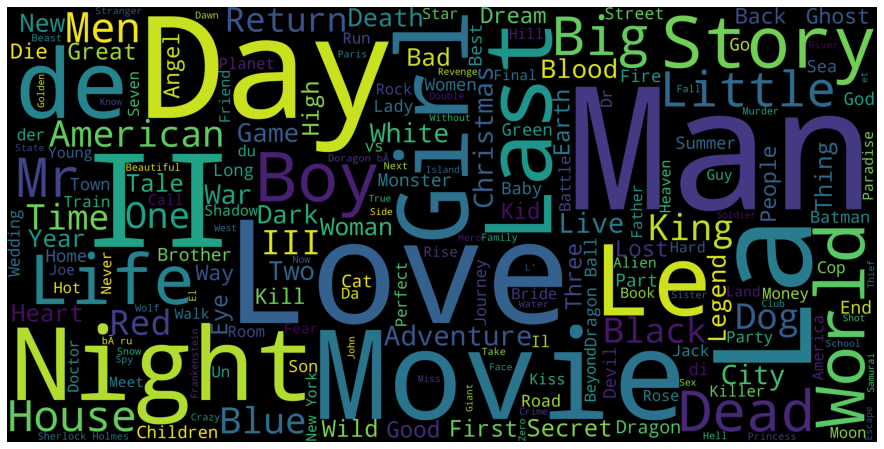

In [ ]:
# Import new libraries
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [ ]:
# Get summary statistics of rating
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


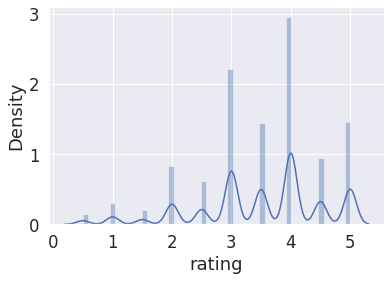

In [ ]:
# Import seaborn library
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.distplot(ratings['rating'].fillna(ratings['rating'].median()))

In [ ]:
# Join all 3 files into one dataframe
dataset = pd.merge(movies, ratings)
# Display 20 movies with highest ratings
dataset[['title','genres','rating']].sort_values('rating', ascending=False).head(20)

,title,genres,rating
56251,Eraserhead (1977),Drama|Horror,5.0
33888,Chasing Amy (1997),Comedy|Drama|Romance,5.0
20742,My Fair Lady (1964),Comedy|Drama|Musical|Romance,5.0
10168,Forrest Gump (1994),Comedy|Drama|Romance|War,5.0
10169,Forrest Gump (1994),Comedy|Drama|Romance|War,5.0
65379,Gosford Park (2001),Comedy|Drama|Mystery,5.0
10171,Forrest Gump (1994),Comedy|Drama|Romance|War,5.0
20739,My Fair Lady (1964),Comedy|Drama|Musical|Romance,5.0
10173,Forrest Gump (1994),Comedy|Drama|Romance|War,5.0
10174,Forrest Gump (1994),Comedy|Drama|Romance|War,5.0


- 많이 나온 장르 추출, wordCloud로 나타내기

In [ ]:
# Make a census of the genre keywords
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 4361],
 ['Comedy', 3756],
 ['Thriller', 1894],
 ['Action', 1828],
 ['Romance', 1596]]

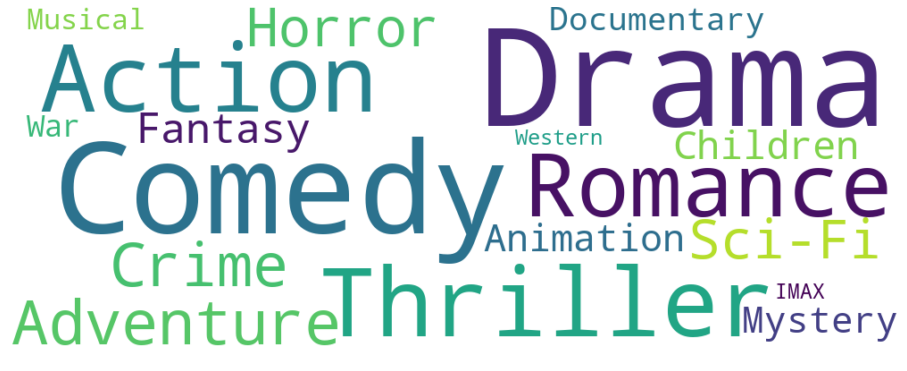

In [ ]:
# Define the dictionary used to produce the genre wordcloud
genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()